In [146]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import spacy
nlp = spacy.load("en_core_web_sm")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asap-aes/valid_sample_submission_1_column.csv
/kaggle/input/asap-aes/Training_Materials.zip
/kaggle/input/asap-aes/training_set_rel3.xls
/kaggle/input/asap-aes/valid_sample_submission_1_column_no_header.csv
/kaggle/input/asap-aes/Essay_Set_Descriptions.zip
/kaggle/input/asap-aes/training_set_rel3.xlsx
/kaggle/input/asap-aes/valid_set.xls
/kaggle/input/asap-aes/training_set_rel3.tsv
/kaggle/input/asap-aes/valid_sample_submission_5_column.csv
/kaggle/input/asap-aes/valid_set.xlsx
/kaggle/input/asap-aes/valid_set.tsv
/kaggle/input/asap-aes/test_set.tsv
/kaggle/input/asap-aes/valid_sample_submission_2_column.csv


In [142]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [94]:
!pip install language-tool-python

In [22]:
from sklearn.model_selection import train_test_split


In [95]:
df = pd.read_excel("/kaggle/input/asap-aes/training_set_rel3.xlsx")

In [96]:
df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df.shape


(12978, 28)

In [26]:
!pip install nltk

^C
ERROR: Operation cancelled by user


In [98]:
import nltk


# EDA

# Insights
* Essay Set 1 has the most essays and essay set 8 has least numbers of essays

In [99]:
df.rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target_score'}, inplace=True)

In [100]:
df.head()


,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df = df[['essay_id', 'topic', 'essay', 'target_score']]


In [102]:
df.head()

,essay_id,topic,essay,target_score
0,1,1,"Dear local newspaper, I think effects computer...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [103]:
df['word_count'] = df['essay'].apply(lambda x: len(x.split()))

In [104]:
df[['target_score', 'word_count']].corr()

,target_score,word_count
target_score,1.000000,0.586467
word_count,0.586467,1.000000


In [106]:
text = df.essay[1871]
text

'I do think that there should be a censorship in not just in libaries, but everywhare.       Personlly, I think that the way that the libraries have the books are appropite and if the parents do not want thier children going any where  that is not privy to them keep a hand lenght away     As for the parents, the parents know the aera that intrest them ,therefor the parents should go there'

In [127]:
import language_tool_python

tool = language_tool_python.LanguageTool('en-US')

matches = tool.check(text)

tool.correct(text, matches)

TypeError: LanguageTool.correct() takes 2 positional arguments but 3 were given

In [128]:
import language_tool_python
import datetime
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://www.languagetool.org/dev
"""
tool = language_tool_python.LanguageTool('en-US')

# t0 = datetime.now()

df['matches'] = df['essay'].apply(lambda txt: tool.check(txt))
df['corrections'] = df.apply(lambda l: len(l['matches']), axis=1)
df['corrected'] = df.apply(lambda l: tool.correct(l['essay']), axis=1)

# t1 = datetime.now()
# print('Processing time: {}'.format(t1 - t0))

# save work


In [130]:
df.head()

,essay_id,topic,essay,target_score,word_count,matches,corrections,corrected
0,1,1,"Dear local newspaper, I think effects computer...",8.0,338,"[Offset 218, length 6, Rule ID: MORFOLOGIK_RUL...",16,"Dear local newspaper, I think effects computer..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,419,"[Offset 148, length 8, Rule ID: MORFOLOGIK_RUL...",25,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,279,"[Offset 315, length 4, Rule ID: MORFOLOGIK_RUL...",17,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,524,"[Offset 86, length 7, Rule ID: MORFOLOGIK_RULE...",29,"Dear Local Newspaper, @CAPS1 I have found that..."
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0,465,"[Offset 177, length 8, Rule ID: MORFOLOGIK_RUL...",17,"Dear @LOCATION1, I know having computers has a..."


In [123]:
df.to_pickle('training_corr.pkl')

In [131]:
df.to_csv('final.csv', index=False)


In [35]:
from textblob import TextBlob

data = TextBlob(text)
print (TextBlob(text).correct())

I do think that there should be a censorship in not just in libraries, but everywhere.       Personally, I think that the way that the libraries have the books are appropriate and if the parents do not want their children going any where  that is not drive to them keep a hand length away     Is for the parents, the parents know the area that interest them ,therefore the parents should go there


In [38]:
df.head()

,essay_id,topic,essay,target_score,word_count
0,1,1,"Dear local newspaper, I think effects computer...",8.0,338
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,419
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,279
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,524
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0,465


In [ ]:
df.to_pickle('training_corr.pkl')


<AxesSubplot: >

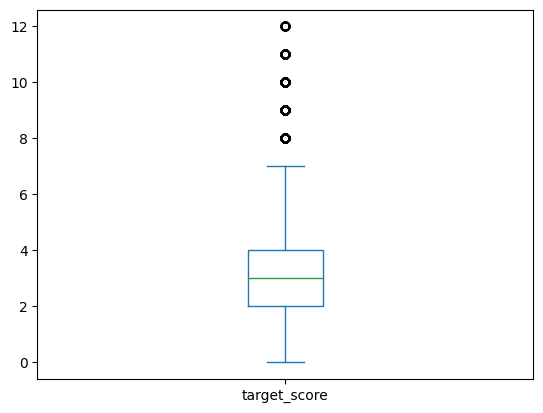

In [39]:
df[df['topic'] < 7]['target_score'].plot(kind='box')

In [41]:
df['target_score'].agg(["min", "max", "mean", 'count', "nunique"])

min            0.000000
max           60.000000
mean           6.799723
count      12977.000000
nunique       53.000000
Name: target_score, dtype: float64

/tmp/ipykernel_31/1086820251.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['topic'] < 7]['target_score'].values)


<AxesSubplot: ylabel='Density'>

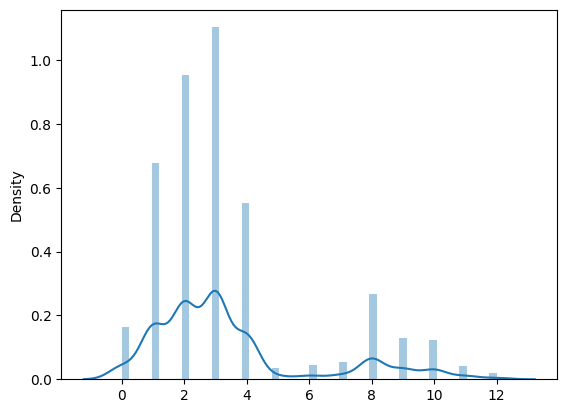

In [40]:
sns.distplot(df[df['topic'] < 7]['target_score'].values)

/tmp/ipykernel_31/2235172493.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['topic'] == 7]['target_score'].values)


<AxesSubplot: ylabel='Density'>

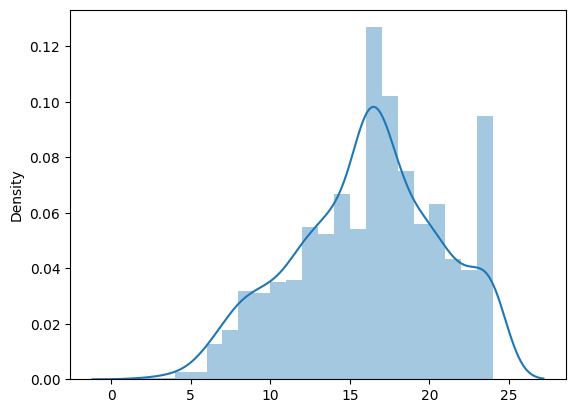

In [42]:
sns.distplot(df[df['topic'] == 7]['target_score'].values)

In [43]:
df[df['topic'] == 7]['word_count'].describe()

count    1569.000000
mean      168.184194
std        85.276560
min         5.000000
25%       105.000000
50%       154.000000
75%       215.000000
max       592.000000
Name: word_count, dtype: float64

<AxesSubplot: >

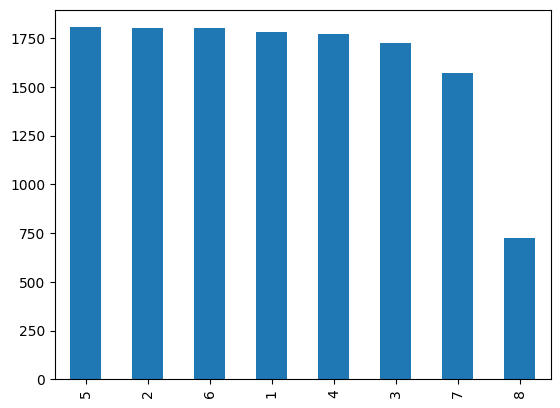

In [44]:
df['topic'].value_counts().plot.bar()

<AxesSubplot: xlabel='topic'>

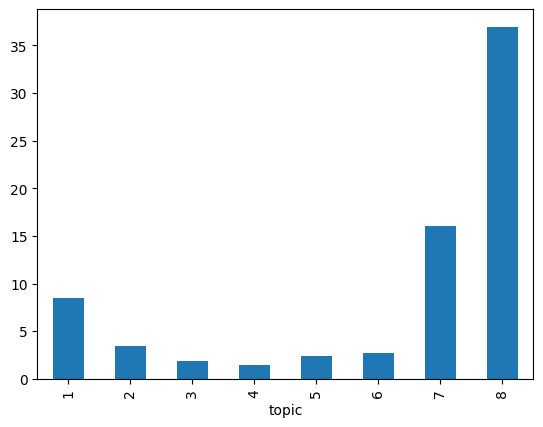

In [45]:
df.groupby(['topic'])['target_score'].mean().plot.bar()

In [46]:
df['target_score'].describe()

count    12977.000000
mean         6.799723
std          8.970558
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max         60.000000
Name: target_score, dtype: float64

In [47]:
new_df = df

<AxesSubplot: ylabel='Count'>

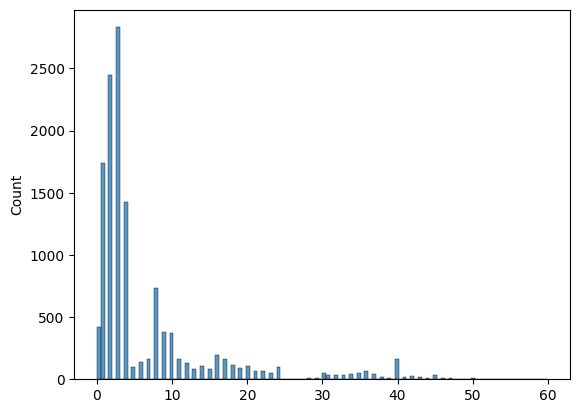

In [48]:
sns.histplot(new_df['target_score'].values)

In [49]:
new_df['target_score'].describe()

count    12977.000000
mean         6.799723
std          8.970558
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max         60.000000
Name: target_score, dtype: float64

In [50]:
new_df = new_df[new_df['topic'] < 7]

In [51]:
# Finding the IQR
percentile25 = new_df['target_score'].quantile(0.25)
percentile75 = new_df['target_score'].quantile(0.75)

In [52]:
percentile25

2.0

In [53]:
percentile75

4.0

In [54]:
iqr = percentile75 - percentile25
iqr

2.0

In [55]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print("Upper_Bound" , upper_limit)
print("Lower_Bound" , lower_limit)

Upper_Bound 7.0
Lower_Bound -1.0


In [56]:
new_df.shape

(10686, 5)

/tmp/ipykernel_31/197312137.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['target_score'].values)


<AxesSubplot: ylabel='Density'>

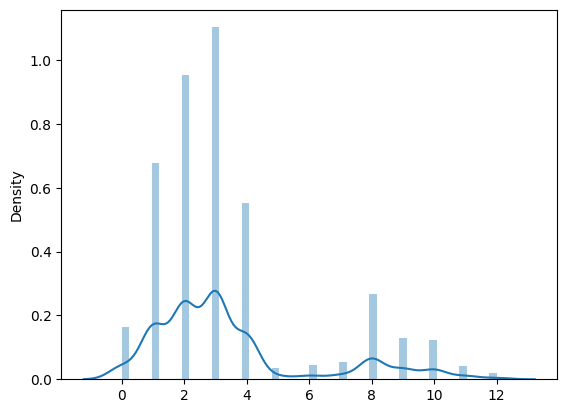

In [57]:
sns.distplot(new_df['target_score'].values)

In [ ]:
# new_df[(new_df['target_score'] < upper_limit) & (new_df['target_score'] > lower_limit)]['target_score'].plot(kind='box')

# Capping

In [58]:
new_df_cap = new_df.copy()

new_df_cap['target_score'] = np.where(
    new_df_cap['target_score'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['target_score'] < lower_limit,
        lower_limit,
       new_df_cap['target_score']
    )
)

In [59]:
new_df['target_score'].value_counts()

3.0     2829
2.0     2444
1.0     1736
4.0     1420
8.0      687
0.0      419
9.0      334
10.0     316
7.0      135
6.0      117
11.0     109
5.0       92
12.0      47
Name: target_score, dtype: int64

<AxesSubplot: >

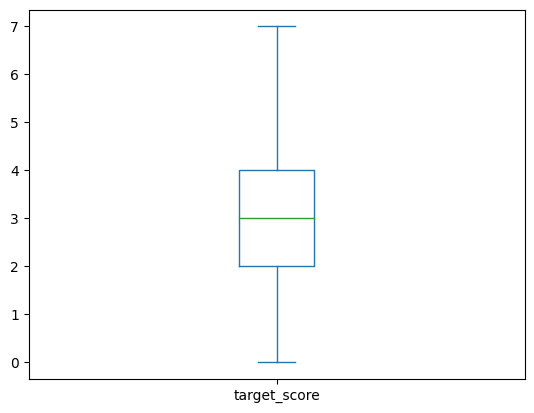

In [60]:
new_df_cap['target_score'].plot(kind='box')

<AxesSubplot: >

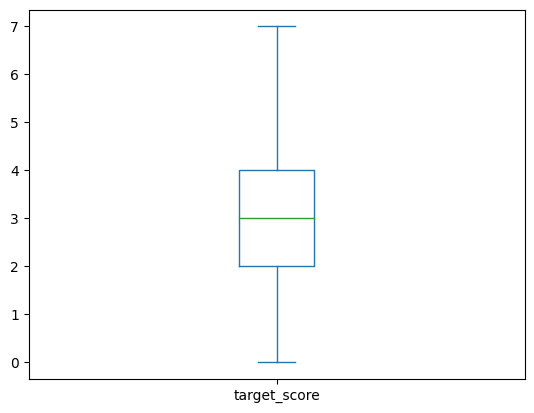

In [61]:
new_df_cap['target_score'].plot(kind='box')

/tmp/ipykernel_31/729147495.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['target_score'].values)


<AxesSubplot: ylabel='Density'>

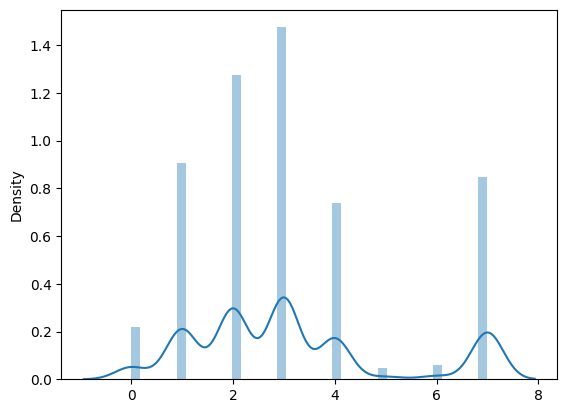

In [62]:
sns.distplot(new_df_cap['target_score'].values)

/tmp/ipykernel_31/729147495.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['target_score'].values)


<AxesSubplot: ylabel='Density'>

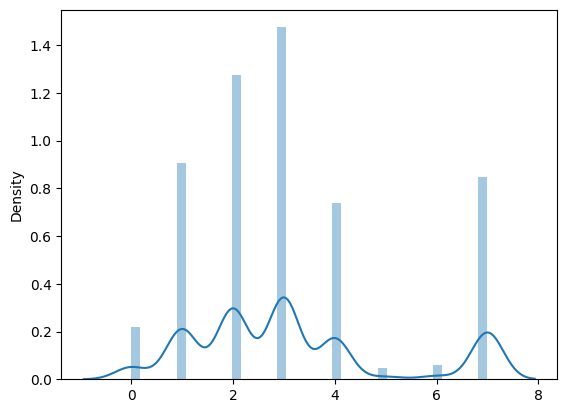

In [63]:
sns.distplot(new_df_cap['target_score'].values)

In [64]:
new_df_cap['target_score'].describe()

count    10685.000000
mean         3.121104
std          1.980136
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: target_score, dtype: float64

/tmp/ipykernel_31/2235172493.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['topic'] == 7]['target_score'].values)


<AxesSubplot: ylabel='Density'>

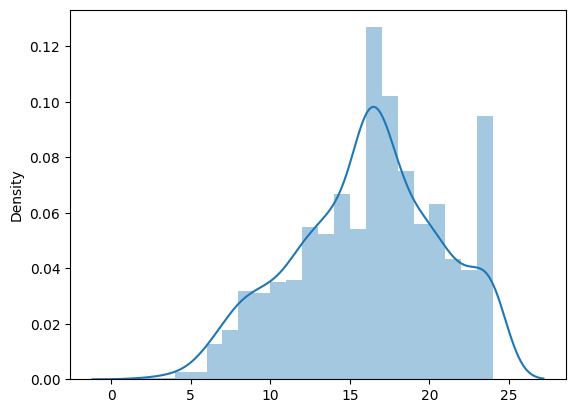

In [65]:
sns.distplot(df[df['topic'] == 7]['target_score'].values)

In [66]:
df[df['topic'] == 7]['target_score'].value_counts()

16.0    199
17.0    160
18.0    118
14.0    105
20.0     99
24.0     96
19.0     88
12.0     86
15.0     85
13.0     82
21.0     68
22.0     62
11.0     56
10.0     55
23.0     53
8.0      50
9.0      49
7.0      28
6.0      20
4.0       4
5.0       4
2.0       1
3.0       1
Name: target_score, dtype: int64

In [67]:
new_df_cap.groupby(['topic'])['target_score'].agg(["min", "max", "mean", 'count', "nunique"])

,min,max,mean,count,nunique
topic,,,,,
1,2.0,7.0,6.860348,1783,6
2,1.0,6.0,3.415556,1800,6
3,0.0,3.0,1.848204,1726,4
4,0.0,3.0,1.431395,1771,4
5,0.0,4.0,2.408864,1805,5
6,0.0,4.0,2.720000,1800,5


<AxesSubplot: xlabel='target_score', ylabel='Count'>

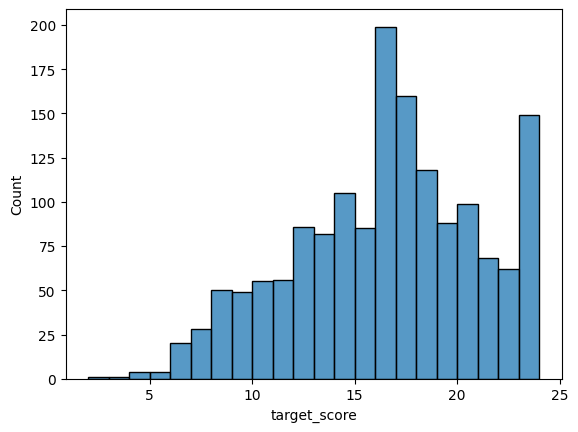

In [68]:
sns.histplot(df[df['topic'] == 7]['target_score'])

In [69]:
scaler = MinMaxScaler(feature_range=(1, 9))

scaler.fit(new_df_cap['target_score'].values.reshape(-1, 1))

scaled_data = scaler.transform(new_df_cap['target_score'].values.reshape(-1, 1))

In [70]:
topic_seven_data = df[df['topic'] == 7]

In [71]:
topic_seven_data.shape

(1569, 5)

In [72]:
topic_seven_data['target_score'].head()

10686    15.0
10687    13.0
10688    15.0
10689    17.0
10690    13.0
Name: target_score, dtype: float64

In [73]:
scaler.fit(topic_seven_data['target_score'].values.reshape(-1, 1))

scaled_data_topic_seven = scaler.transform(topic_seven_data['target_score'].values.reshape(-1, 1))

In [74]:
topic_seven_data['scaled_target_score'] = scaled_data_topic_seven

/tmp/ipykernel_31/2280847560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_seven_data['scaled_target_score'] = scaled_data_topic_seven


In [75]:
topic_seven_data['scaled_target_score']

10686    5.727273
10687    5.000000
10688    5.727273
10689    6.454545
10690    5.000000
           ...   
12250    4.636364
12251    6.090909
12252    7.181818
12253    8.272727
12254    5.727273
Name: scaled_target_score, Length: 1569, dtype: float64

In [76]:
new_df_cap['scaled_target_score'] = scaled_data

In [77]:
new_df_cap['scaled_target_score'].describe()

count    10685.000000
mean         4.566976
std          2.263012
min          1.000000
25%          3.285714
50%          4.428571
75%          5.571429
max          9.000000
Name: scaled_target_score, dtype: float64

In [78]:
new_df_cap = pd.concat([new_df_cap, topic_seven_data], ignore_index=True)


In [79]:
new_df_cap['scaled_target_score'].describe()

count    12254.000000
mean         4.765009
std          2.255731
min          1.000000
25%          3.285714
50%          4.428571
75%          5.571429
max          9.000000
Name: scaled_target_score, dtype: float64

In [80]:
new_df_cap.head()

,essay_id,topic,essay,target_score,word_count,scaled_target_score
0,1,1,"Dear local newspaper, I think effects computer...",7.0,338,9.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7.0,419,9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,279,9.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",7.0,524,9.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",7.0,465,9.0


In [81]:
main_df = new_df_cap[['essay_id', 'topic', 'essay', 'target_score', 'scaled_target_score', 'word_count']]

In [82]:
main_df.shape

(12255, 6)

In [ ]:
main_df.describe()

In [ ]:
sns.distplot(main_df['target_score'])

In [ ]:
sns.distplot(main_df['scaled_target_score'])

In [ ]:
main_df['target_score'].plot(kind='box')

In [ ]:
main_df['scaled_target_score'].plot(kind='box')

In [ ]:
# Create a dataframe
# Export the dataframe to a CSV file
main_df.to_csv('my_dataframe.csv', index=False)

# Click on the "Output" tab in the notebook viewer
# Click on the "Download" button next to the CSV file

In [ ]:
df['target_score'].mean()

In [ ]:
df['scaled_target_score'].plot(kind='box')

In [ ]:
# df[['word_count','target_score']].corr()
main_df.groupby(['topic'])[['word_count', 'target_score']].corr()
